<a href="https://colab.research.google.com/github/mori8/NLP-laboratory/blob/main/%08word2vec_SGNS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from sklearn.datasets import fetch_20newsgroups
from tensorflow.keras.preprocessing.text import Tokenizer

In [2]:
# to avoid LookupError
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [51]:
dataset = fetch_20newsgroups(shuffle=True, random_state=1, remove=('headers', 'footers', 'quotes'))
documents = dataset.data
print('총 샘플 수 :',len(documents))

총 샘플 수 : 11314


In [52]:
# 전처리
news_df = pd.DataFrame({'document':documents})
# 특수 문자 제거
news_df['clean_doc'] = news_df['document'].str.replace("[^a-zA-Z]", " ")
# 길이가 3 이하인 단어는 제거
news_df['clean_doc'] = news_df['clean_doc'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))
# 전체 단어에 대한 소문자 변환
news_df['clean_doc'] = news_df['clean_doc'].apply(lambda x: x.lower())

In [53]:
news_df.isnull().values.any()

False

In [54]:
news_df.replace("", float("NaN"), inplace=True)
news_df.isnull().values.any()

True

In [55]:
# Null 제거
news_df.dropna(inplace=True)
print('data length:', len(news_df))

data length: 10995


In [56]:
# stopwords 제거
stop_words = stopwords.words('english')
tokenized_doc = news_df['clean_doc'].apply(lambda x: x.split())
# nltk에서 정한 stopword 리스트를 사용해 stopword 제거
tokenized_doc = tokenized_doc.apply(lambda x: [item for item in x if item not in stop_words])
tokenized_doc = tokenized_doc.to_list()

In [57]:
# 단어가 1개 이하인 샘플의 인덱스를 찾아서 저장하고, 해당 샘플들은 제거
drop_train = [index for index, sentence in enumerate(tokenized_doc) if len(sentence) <= 1]
tokenized_doc = np.delete(tokenized_doc, drop_train, axis=0)
print('총 샘플 수 :',len(tokenized_doc))

총 샘플 수 : 10940


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [58]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(tokenized_doc)

word2idx = tokenizer.word_index
idx2word = {value : key for key, value in word2idx.items()}
encoded = tokenizer.texts_to_sequences(tokenized_doc)

In [59]:
print(encoded[:2])

[[9, 59, 603, 207, 3278, 1495, 474, 702, 9470, 13686, 5533, 15227, 702, 442, 702, 70, 1148, 1095, 1036, 20294, 984, 705, 4294, 702, 217, 207, 1979, 15228, 13686, 4865, 4520, 87, 1530, 6, 52, 149, 581, 661, 4406, 4988, 4866, 1920, 755, 10668, 1102, 7837, 442, 957, 10669, 634, 51, 228, 2669, 4989, 178, 66, 222, 4521, 6066, 68, 4295], [1026, 532, 2, 60, 98, 582, 107, 800, 23, 79, 4522, 333, 7838, 864, 421, 3825, 458, 6488, 458, 2700, 4730, 333, 23, 9, 4731, 7262, 186, 310, 146, 170, 642, 1260, 107, 33568, 13, 985, 33569, 33570, 9471, 11491]]


In [60]:
vocab_size = len(word2idx) + 1
print('단어 집합의 크기:', vocab_size)

단어 집합의 크기: 64277


## Negative Sampling

In [61]:
# 네거티브 샘플링을 통한 데이터셋 구성하기
# 시간 없으니 상위 10개만
from tensorflow.keras.preprocessing.sequence import skipgrams
# 네거티브 샘플링
skip_grams = [skipgrams(sample, vocabulary_size=vocab_size, window_size=10) for sample in encoded[:10]]

In [62]:
# 첫번째 뉴스그룹 샘플(skip_grams[0])
pairs, labels = skip_grams[0][0], skip_grams[0][1]
for i in range(5):
    print("({:s} ({:d}), {:s} ({:d})) -> {:d}".format(
          idx2word[pairs[i][0]], pairs[i][0], 
          idx2word[pairs[i][1]], pairs[i][1], 
          labels[i]))

(realize (1036), friendly (3028)) -> 0
(letter (705), production (1905)) -> 0
(statement (474), well (9)) -> 1
(letter (705), attleboro (29685)) -> 0
(disagree (1495), gesi (37949)) -> 0


윈도우 크기 내에서 중심 단어-주변 단어의 관계를 가지는 경우에는 1, 아닌 경우는 0의 레이블을 가지도록 한다.

In [63]:
print('전체 샘플 수:', len(skip_grams))

전체 샘플 수: 10


In [64]:
print(len(pairs))
print(len(labels))

2220
2220


## Skip-Gram with Negative Sampling

In [65]:
# skip-gram 직접 구현해보기
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, Reshape, Activation, Input, Dot
from tensorflow.keras.utils import plot_model
from IPython.display import SVG

In [66]:
embed_size = 100

In [67]:
# 중심 단어를 위한 임베딩 테이블
w_inputs = Input(shape=(1, ), dtype='int32')
word_embedding = Embedding(vocab_size, embed_size)(w_inputs)

# 주변 단어를 위한 임베딩 테이블
c_inputs = Input(shape=(1, ), dtype='int32')
context_embedding  = Embedding(vocab_size, embed_size)(c_inputs)

In [68]:
dot_product = Dot(axes=2)([word_embedding, context_embedding])
dot_product = Reshape((1,), input_shape=(1, 1))(dot_product)
output = Activation('sigmoid')(dot_product)

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_8 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 embedding_6 (Embedding)        (None, 1, 100)       6427700     ['input_7[0][0]']                
                                                                                                  
 embedding_7 (Embedding)        (None, 1, 100)       6427700     ['input_8[0][0]']                
                                                                                            

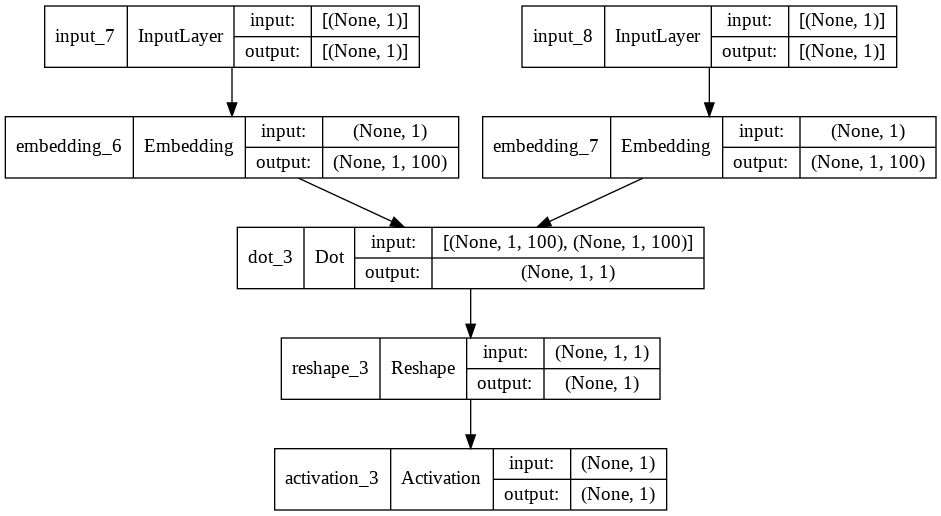

In [69]:
model = Model(inputs=[w_inputs, c_inputs], outputs=output)
model.summary()
model.compile(loss='binary_crossentropy', optimizer='adam')
plot_model(model, to_file='model3.png', show_shapes=True, show_layer_names=True, rankdir='TB')

In [83]:
for epoch in range(1, 16):
    loss = 0
    for _, elem in enumerate(skip_grams):
        first_elem = np.array(list(zip(*elem[0]))[0], dtype='int32')
        second_elem = np.array(list(zip(*elem[0]))[1], dtype='int32')
        labels = np.array(elem[1], dtype='int32')
        X = [first_elem, second_elem]
        Y = labels
        loss += model.train_on_batch(X,Y)  
    print('Epoch :',epoch, 'Loss :',loss)

Epoch : 1 Loss : 5.525849640369415
Epoch : 2 Loss : 5.326479494571686
Epoch : 3 Loss : 5.118135303258896
Epoch : 4 Loss : 4.902800440788269
Epoch : 5 Loss : 4.682548254728317
Epoch : 6 Loss : 4.459476500749588
Epoch : 7 Loss : 4.235641688108444
Epoch : 8 Loss : 4.013004004955292
Epoch : 9 Loss : 3.7933753430843353
Epoch : 10 Loss : 3.5783813297748566
Epoch : 11 Loss : 3.369431287050247
Epoch : 12 Loss : 3.1677019596099854
Epoch : 13 Loss : 2.9741309881210327
Epoch : 14 Loss : 2.789421021938324
Epoch : 15 Loss : 2.614051416516304


In [71]:
# 결과 확인
import gensim

In [84]:
f = open('vectors.txt' ,'w')
f.write('{} {}\n'.format(vocab_size-1, embed_size))
vectors = model.get_weights()[0]
for word, i in tokenizer.word_index.items():
    f.write('{} {}\n'.format(word, ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [85]:
w2v = gensim.models.KeyedVectors.load_word2vec_format('./vectors.txt', binary=False)
w2v.most_similar(positive=['soldiers'])

[('makes', 0.7283537983894348),
 ('received', 0.6690194010734558),
 ('commited', 0.6556481719017029),
 ('away', 0.6410380005836487),
 ('treating', 0.634045422077179),
 ('reports', 0.6109390258789062),
 ('guilt', 0.5938081741333008),
 ('races', 0.5865753889083862),
 ('acts', 0.5809345841407776),
 ('unfortunate', 0.5763115882873535)]

In [86]:
w2v.most_similar(positive=['doctor'])

[('abilities', 0.368651807308197),
 ('consensually', 0.3653196096420288),
 ('ripcam', 0.36467552185058594),
 ('trachtenberg', 0.3608926236629486),
 ('modality', 0.3573950231075287),
 ('kabbalat', 0.3567562997341156),
 ('leksand', 0.3554874062538147),
 ('bouhdiba', 0.35417884588241577),
 ('tribulation', 0.35192084312438965),
 ('summarize', 0.35137879848480225)]

In [87]:
w2v.most_similar(positive=['knife'])

[('bombards', 0.398502916097641),
 ('mendez', 0.3905550241470337),
 ('pxphigs', 0.38821685314178467),
 ('unsullied', 0.3749113082885742),
 ('iyup', 0.362787663936615),
 ('scanfirstline', 0.34998488426208496),
 ('equipement', 0.34885773062705994),
 ('nacional', 0.3474619388580322),
 ('fayettville', 0.34677624702453613),
 ('satisfac', 0.3454171121120453)]

In [88]:
w2v.most_similar(positive=['engine'])

[('frammitzes', 0.3882414698600769),
 ('remedial', 0.3878495693206787),
 ('role', 0.3819655776023865),
 ('penned', 0.3701178729534149),
 ('decorative', 0.36992087960243225),
 ('sense', 0.3649899363517761),
 ('gryaznov', 0.36210185289382935),
 ('eskimo', 0.35961824655532837),
 ('ftpuf', 0.35822221636772156),
 ('atom', 0.3541772663593292)]